In [1]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 创建数据集，继承自torch.utils.data.Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):    # 获取数据
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [file for file in os.listdir(root_dir) if file.endswith('.jpg')]
        
    def __len__(self):   # 使用数据的长度
        return len(self.file_list)
    
    def __getitem__(self, idx):  # 返回指定索引idx的数据和标签
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)
        label = 1 if 'dog' in self.file_list[idx] else 0  # 狗为1，猫为0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_data_path = 'C:\\Users\\Fan\\JupyterFile\\data\\Dog_Cat\\train1'
batch_size = 128

# 预处理
transform = transforms.Compose([
    transforms.Resize((256,256)),  # 调整图像大小LeNet
    #transforms.Resize((224,224)),  # 调整图像大小VGG16
    transforms.ToTensor(),         # 转换为Tensor张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 创建训练集和测试集
train_dataset = CustomDataset(root_dir=train_data_path, transform=transform)
train_size = int(0.8 * len(train_dataset))  # 使用80%的数据作为训练集
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])
# torch.Size([32, 3, 64, 64])
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

cuda


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # 输入层
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*61*61, 120)           # ？
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)                   # 输出层

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))         # 第一层卷积        256-->252
        x = nn.functional.max_pool2d(x, 2)            # 池化              252-->126
        x = nn.functional.relu(self.conv2(x))         # 第二层卷积        126-->122
        x = nn.functional.max_pool2d(x, 2)            # 池化              122-->？= 61
        x = x.view(-1, 16*61*61)                      # 将特征图展平
        x = nn.functional.relu(self.fc1(x))           # 全连接
        x = nn.functional.relu(self.fc2(x))           # 全连接
        x = self.fc3(x)                               # 输出
        return x    

In [4]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()    # input:224*224*3

        # GROUP 1 input:224*224*3
        self.conv1_1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=(1,1)) #output:224*224*64   padding=(1,1)在四周添加数据
        self.conv1_2 = nn.Conv2d(in_channels=64,out_channels=64 ,kernel_size=3,stride=1,padding=(1,1))#output:224*224*64
        self.maxpool1 = nn.MaxPool2d(2)#池化output:112*112*64

        # GROUP 2 input::112*112*64
        self.conv2_1 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=(1,1))#output:112*112*128
        self.conv2_2 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=(1,1))#output:112*112*128
        self.maxpool2 = nn.MaxPool2d(2)#池化output:56*56*128

        # GROUP 3 input:56*56*128
        self.conv3_1 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=(1,1))#output:56*56*256
        self.conv3_2 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=(1,1))#output:56*56*256
        self.conv3_3 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1)#output:56*56*256
        self.maxpool3 = nn.MaxPool2d(2)  # 池化output:28*28*256

        # GROUP 4 input:28*28*256
        self.conv4_1 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=(1,1))#output:28*28*512
        self.conv4_2 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=(1,1))#output:28*28*512
        self.conv4_3 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,stride=1)#output:28*28*512
        self.maxpool4 = nn.MaxPool2d(2)  # 池化output:14*14*512

        # GROUP 5 input:14*14*512
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=(1,1))  # output:14*14*512
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=(1,1))  # output:14*14*512
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1)  # output:14*14*512
        self.maxpool5 = nn.MaxPool2d(2)  # 池化后长宽减半 output:7*7*512

        self.fc1 = nn.Linear(in_features=7*7*512,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=2)

    #前向传播
    def forward(self,x):
        input_dimen = x.size(0)

        #GROUP 1
        output = self.conv1_1(x)
        output = F.relu(output)
        output = self.conv1_2(output)
        output = F.relu(output)
        output = self.maxpool1(output)

        #GROUP 2
        output = self.conv2_1(output)
        output = F.relu(output)
        output = self.conv2_2(output)
        output = F.relu(output)
        output = self.maxpool2(output)

        #GROUP 3
        output = self.conv3_1(output)
        output = F.relu(output)
        output = self.conv3_2(output)
        output = F.relu(output)
        output = self.conv3_3(output)
        output = F.relu(output)
        output = self.maxpool3(output)

        #GROUP 4
        output = self.conv4_1(output)
        output = F.relu(output)
        output = self.conv4_2(output)
        output = F.relu(output)
        output = self.conv4_3(output)
        output = F.relu(output)
        output = self.maxpool4(output)

        #GROUP 5
        output = self.conv5_1(output)
        output = F.relu(output)
        output = self.conv5_2(output)
        output = F.relu(output)
        output = self.conv5_3(output)
        output = F.relu(output)
        output = self.maxpool5(output)

        output = output.view(x.size(0),-1)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        
        return output

Epoch [1/1000], Loss: 0.7379218850816999
Epoch [51/1000], Loss: 2.0908851963343166e-05
Epoch [101/1000], Loss: 2.7564674058209804e-06
Epoch [151/1000], Loss: 1.2756788204829457e-06
Epoch [201/1000], Loss: 7.202280869478273e-07
Epoch [251/1000], Loss: 4.834801917549417e-07
Epoch [301/1000], Loss: 3.617173080426385e-07
Epoch [351/1000], Loss: 2.7884918019083216e-07
Epoch [401/1000], Loss: 2.3686982940164724e-07
Epoch [451/1000], Loss: 1.9735873938283737e-07
Epoch [501/1000], Loss: 1.7977933757557756e-07
Epoch [551/1000], Loss: 1.563458137557713e-07
Epoch [601/1000], Loss: 1.2827331425618077e-07
Epoch [651/1000], Loss: 1.3227959121715166e-07
Epoch [701/1000], Loss: 1.0368076581406577e-07
Epoch [751/1000], Loss: 9.75991683662057e-08
Epoch [801/1000], Loss: 9.254051950132894e-08
Epoch [851/1000], Loss: 8.173724808102634e-08
Epoch [901/1000], Loss: 7.579161222435817e-08
Epoch [951/1000], Loss: 6.875203745997688e-08
测试集正确率：60.29%


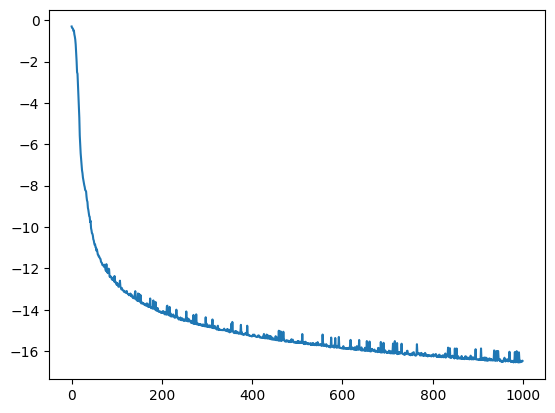

In [5]:
model=LeNet().to(device)
# 训练模型
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)
losses=[]
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()   # 训练模式，打开参数更新
    running_loss = 0.0
    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    losses.append(running_loss/len(train_loader))
# 模型测试
model.eval()   # 评价模式，禁止参数更新
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'测试集正确率：{(correct / total) * 100:.2f}%')
plt.plot(np.log(losses))
plt.show()

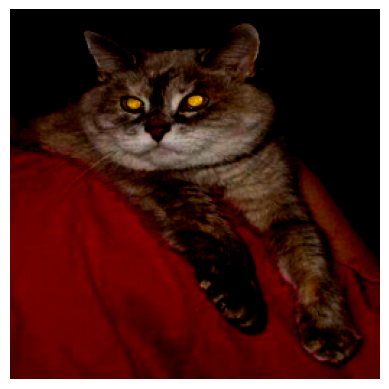

Pre: 0, Truth: 0


In [7]:
# 测试集预测结果
def show_image(tensor):
    tensor=torch.clamp(tensor,0,1)
    tensor = tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow(tensor)
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    

show_image(images[i])
print(f"Pre: {predicted[i].item()}, Truth: {labels[i].item()}")